In [1]:
# Cell 1 ‑‑‑ imports and cube loading
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.io import fits
from astropy import units as u
from astropy import constants as c

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

In [2]:


# --------- file location (edit if needed) ----------
cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
print("Loading:", cube_path.resolve())

with fits.open(cube_path) as hdul:
    data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
    stat = hdul["STAT"].data.astype(np.float32)
    dq   = hdul["DQ"].data.astype(np.uint8)
    hdr  = hdul["DATA"].header

nz, ny, nx = data.shape
print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
hdr
hdul.close()


Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits
Cube dimensions  →  nz = 3761,  ny = 438,  nx = 437


In [3]:
# Cell 2  –– wavelength array (Å), λ‑cut, velocity scale
from astropy.wcs import WCS

# --- 2.1 build wavelength array in Å ---
wcs_3d = WCS(hdr)                       # 3‑D WCS (RA, Dec, λ)
spec_pix = np.arange(nz)                # spectral pixel indices (0 … nz‑1)
lam_min = 4750.0                     # min λ in Å
lam_max = 7050.0                     # max λ in Å

# all_pix2world returns metres for the spectral axis in this cube → convert to Å
lam_m  = wcs_3d.all_pix2world(
             np.zeros_like(spec_pix),   # dummy RA
             np.zeros_like(spec_pix),   # dummy Dec
             spec_pix,                  # spectral pixel
             0)[2]                      # wavelength [m]
lam_ang = lam_m * 1e10                  # metres → Å

# --- 2.2 keep only λ < 7000 Å ---
cut = (lam_ang >= lam_min) & (lam_ang <= lam_max)
lam_ang = lam_ang[cut]
data    = data[cut, :, :]
stat    = stat[cut, :, :]
dq      = dq[cut,   :, :]
nz      = lam_ang.size                 # update nz after trimming
print(f"After λ‑cut (<=7000 Å)  →  nz = {nz}")

# --- 2.3 compute velocity scale (km s⁻¹ per pixel) ---
c_kms   = c.c.to(u.km/u.s).value        # 299 792.458
dlnλ    = np.diff(np.log(lam_ang))  # dlnλ in Å
velscale = np.min(c_kms * dlnλ) # km/s per pixel
print(f"Velocity scale (min)  →  velscale = {velscale:.2f} km/s")


After λ‑cut (<=7000 Å)  →  nz = 1841
Velocity scale (min)  →  velscale = 53.16 km/s


Integrated spectrum built:
   simple‑sum shape    : (1841,)


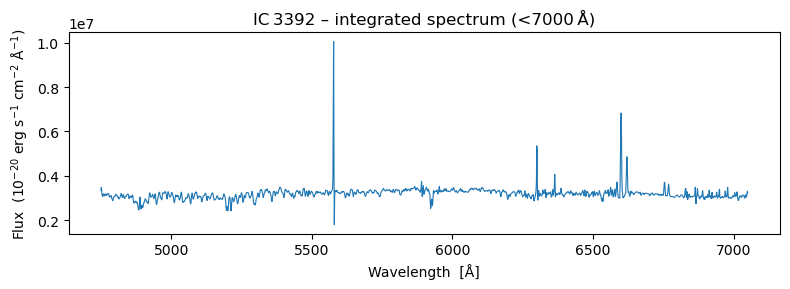

In [4]:
# Cell 3 –– integrate cube to 1‑D spectrum + noise  (v2: NaN‑safe)
# ----------------------------------------------------------------

# ---- 3.1 simple‑sum spectrum ----
flux_sum  = np.nansum(data, axis=(1, 2))          # erg s⁻¹ cm⁻² Å⁻¹
# flux_sum = flux_sum / np.nanmedian(flux_sum)  # normalize to median
noise_wgt = np.sqrt(np.nansum(stat, axis=(1, 2)))  # shape = (nz,)

print("Integrated spectrum built:")
print(f"   simple‑sum shape    : {flux_sum.shape}")

# ---- 3.2 quick plot ----
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel(r"Flux  ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.title("IC 3392 – integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()

# # ---- 3.3 normalized the flux to be near unity ----
# # normalize to the median of the spectrum
# # normalisation = np.nanmedian(flux_sum)
# normalisation = 1
# flux_sum /= normalisation
# noise_wgt /= normalisation
# print("Integrated spectrum normalised:")
# print("Normalisation factor:", normalisation)

# # ---- 3.4 normalized plot ----
# plt.figure(figsize=(8, 3))
# plt.plot(lam_ang, flux_sum, lw=0.8)
# plt.xlabel("Wavelength  [Å]")
# plt.ylabel("Normalized flux")
# plt.title("IC 3392 – integrated spectrum (<7000 Å)")
# plt.tight_layout();  plt.show()

Hα‑based red‑shift  z = 0.00567   (v ≈ 1699.3 km/s)
Masked wavelength bins : 328 of 1841 (17.8 %)


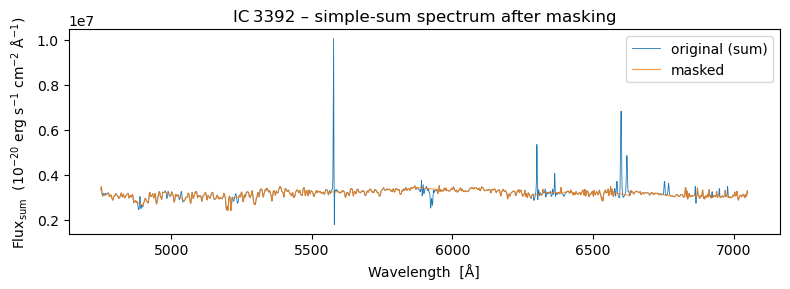

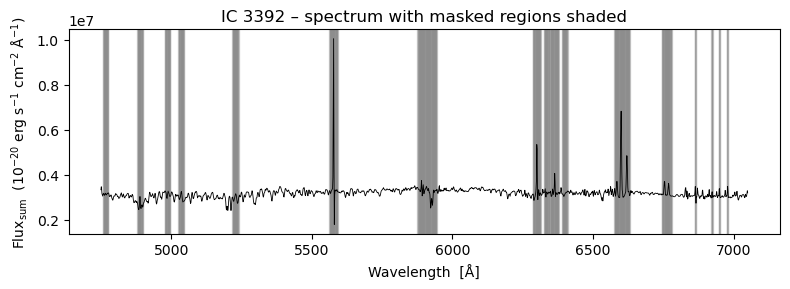

In [5]:
# Cell 4 –– red‑shift guess & dual‑spectra masking (sky ≠ red‑shifted)
# -------------------------------------------------------------------
import numpy as np

# -- 4.1  red‑shift from Hα using the simple‑sum spectrum --------------
h_alpha_lab = 6562.8
win = (lam_ang > 6500) & (lam_ang < 6700)
lam_peak = lam_ang[win][np.nanargmax(flux_sum[win])]
z_guess  = lam_peak / h_alpha_lab - 1
v_guess  = z_guess * c_kms
print(f"Hα‑based red‑shift  z = {z_guess:.5f}   (v ≈ {v_guess:.1f} km/s)")

# -- 4.2  read mask table ------------------------------------------------
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_tbl  = np.genfromtxt("specMask_KIN.txt", dtype=mask_dtype,
                          comments='#', usecols=(0,1,2), encoding=None)

# -- 4.3  construct bad‑pixel mask --------------------------------------
mask_bad = np.zeros_like(lam_ang, dtype=bool)

for lam_rest, width_rest, comment in mask_tbl:
    # sky lines: use rest value directly (no z shift)
    if comment.strip().lower() == 'sky':
        lam_obs   = lam_rest
        width_obs = width_rest
    else:                       # nebular/emission lines → red‑shifted
        lam_obs   = lam_rest  * (1 + z_guess)
        width_obs = width_rest * (1 + z_guess)

    m = (lam_ang > lam_obs - width_obs/2) & (lam_ang < lam_obs + width_obs/2)
    mask_bad |= m

print(f"Masked wavelength bins : {mask_bad.sum()} of {lam_ang.size} "
      f"({100*mask_bad.mean():.1f} %)")

# --- 4.4 replace masked pixels with local mean along the wavelength axis ---

def fill_bad_1d(spec, bad):
    """
    spec : 1‑D array  (your flux vector)
    bad  : 1‑D bool   (True where you want to replace)
    Returns a *new* array with bad entries replaced by the
    mean of the nearest good pixels on either side.
    """
    filled = spec.copy()

    if bad.any():
        good = ~bad
        # np.interp does linear interpolation; for a single pixel gap
        # that is exactly the mean of its two neighbours
        filled[bad] = np.interp(np.flatnonzero(bad),         # x  to fill
                                np.flatnonzero(good),        # x of neighbours
                                spec[good])                  # y of neighbours
    return filled

# 1‑D masks (length = nz)
bad_1d = mask_bad.copy()

flux_sum_masked = fill_bad_1d(flux_sum, bad_1d)

# keep the noise = ∞ so pPXF still gives zero weight there
noise_wgt_masked = noise_wgt.copy()
noise_wgt_masked[bad_1d] = np.inf

# -- 4.5  quick visual check -----------------------
plt.figure(figsize=(8,3))
plt.plot(lam_ang, flux_sum,        lw=0.6, label='original (sum)')
plt.plot(lam_ang, flux_sum_masked, lw=0.8, label='masked', alpha=0.8)
plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – simple‑sum spectrum after masking')
plt.legend();  plt.tight_layout();  plt.show()

# Extract the region that we maks out
lam_ang_masked = lam_ang[bad_1d]
flux_sum_masked = flux_sum_masked[bad_1d]

# ---- outputs for Cell 5 ----
# lam_ang, flux_wgt_masked, noise_wgt_masked, flux_sum_masked

# after building mask_bad:
lam_remove = lam_ang[mask_bad]
lam_good   = lam_ang[~mask_bad]
# Plot the spectrum with the reomve regions with vertical gray shading 
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.6, color = 'black', label='original (sum)')
# shade out the removed wavelength bins
half_bin = np.diff(lam_ang).mean() / 2
for lam in lam_remove:
    plt.axvspan(lam - half_bin, lam + half_bin, color='gray', alpha=0.3)

plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – spectrum with masked regions shaded')
plt.tight_layout()
plt.show()

In [6]:
# Cell 5 –– log‑rebinning the chosen 1‑D spectrum
# -----------------------------------------------
from ppxf import ppxf_util

# ----- 5.0  get spectrum -----

flux_1d_raw  = flux_sum
# noise from summed variances (shot‑noise approximation)
noise_1d_raw = noise_wgt



# --- log‑rebin flux and noise -----------------------------------
# 5.2a  initial rebin just to measure velscale_out
_, _, velscale_out = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw, velscale=velscale, flux=True)

#  rebin flux & noise *with* the measured velscale_out
log_flux, log_lam, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw,
    velscale=velscale_out, flux=True)

log_noise, _, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], noise_1d_raw,
    velscale=velscale_out, flux=False)

# log_rebin for lam_good
_, log_lam_good, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw,
    velscale=velscale_out, flux=True)



print(f"Log‑grid length : {log_flux.size} pixels")
print(f"velscale        : {velscale_out:.3f} km/s")

assert np.isclose(velscale_out, velscale), \
       "Warning: velscale mismatch! Check your data."

# ---- outputs for the next cell ----
#   log_flux, log_noise, log_lam, velscale_out, z_guess


Log‑grid length : 2228 pixels
velscale        : 53.159 km/s


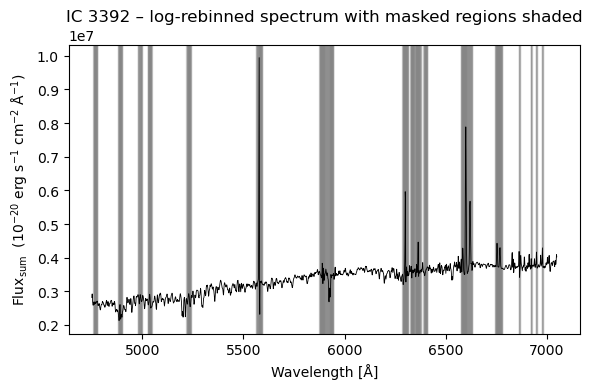

In [7]:
plt.figure(figsize=(6,4))
lam_plot = np.exp(log_lam)
plt.plot(lam_plot, log_flux, 'k-', lw=0.6)
half_bin = np.diff(lam_plot).mean() / 2
for lam in lam_remove:
    plt.axvspan(lam - half_bin, lam + half_bin, color='gray', alpha=0.3)
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – log‐rebinned spectrum with masked regions shaded')
plt.tight_layout()
plt.show()


In [8]:
# Setup SPS templates

# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

FWHM_gal = None   # set this to None to skip templates broadening
print("Loading E‑MILES SSP grid …")
# sps = lib.sps_lib(filename, velscale_out, fwhm_gal=None,
#                   norm_range=[lam_min, 7000]
#                   )    

# linspace the wavelength range
lam_temp_arr = np.linspace(4e3, 1e4, 100000)
# lam_temp_arr = np.arange(4e3, 1e4+1, 1e4)
 
fwhm_gal = {
    "lam": lam_temp_arr,
    "fwhm": 5.866e-8 * lam_temp_arr**2 
            - 9.187e-4 * lam_temp_arr 
            + 6.040
}

sps = lib.sps_lib(
    filename, velscale_out, fwhm_gal,
    norm_range=[lam_min, lam_max],
    lam_range=[4e3, 1e4],
)

# sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar

templates_hr = sps.templates          # (n_wave, n_age, n_Z)
lam_temp_hr  = sps.lam_temp           # length 18 998 Å

print(f"Template wavelength range: {sps.lam_temp[0]:.1f} to {sps.lam_temp[-1]:.1f} Å")

Loading E‑MILES SSP grid …
Template wavelength range: 4000.3 to 9999.9 Å


In [10]:
fwhm_gal

{'lam': array([ 4000.       ,  4000.0600006,  4000.1200012, ...,  9999.8799988,
         9999.9399994, 10000.       ], shape=(100000,)),
 'fwhm': array([3.30376   , 3.30373303, 3.30370607, ..., 2.71896946, 2.71898473,
        2.719     ], shape=(100000,))}

 Best Fit:       Vel     sigma
 comp.  0:      1675        65
Attenuation Parameters 0: 1.653 0.000
chi2/DOF: 834.0; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 9/150
V = 1675.455 km/s,  σ = 64.865 km/s


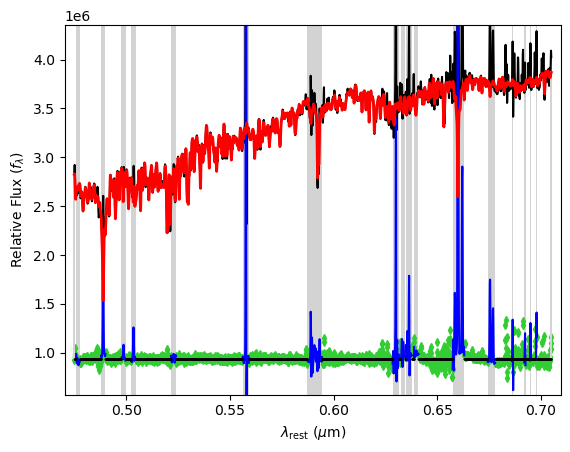

In [11]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
regul_err = 0.01  # Large regularization error

# Compute which rebinned pixels fall on unmasked (good) λ
lam_grid = np.exp(log_lam)                   # rebinned wavelengths in Å
pix      = np.searchsorted(lam_ang, lam_grid)
goodpixels = np.where(~mask_bad[pix])[0]


# Boolean mask telling pPXF which templates see this dust
n_temp         = stars_templates.shape[1]           # total columns
stars_component = np.ones(n_temp, dtype=bool)       # all templates = stars
# If you later append gas templates, set stars_component[:n_star] = True,
#                                                stars_component[n_star:] = False

# 2.  Define the dust dictionary (A_V  and  δ ≡ tilt of the curve)
dust_stars = {
    "start"    : [1., 0],      # initial A_V (mag) and δ
    "bounds"   : [
                  [0.0, 4.0],      # A_V ∈ [0, 4]
                #   [-1.5, 0.4],    # δ   ∈ [–1, 0.4]  (Calzetti-like tilt)
                             ],   
    "component": stars_component,  # Boolean mask defined above
    # "func"   : my_custom_curve   # only if you want your own law
}
dust = [dust_stars]

# Run pPXF only on those good pixels
from ppxf import ppxf

start_V   = v_guess
start_sig = 5 * velscale_out

pp = ppxf.ppxf(
    # templates   = sps.templates,
    templates   = stars_templates,
    galaxy      = log_flux,
    noise       = log_noise,
    velscale    = velscale_out,
    start       = [start_V, start_sig],
    degree      = 12,
    mdegree     = 0,
    moments     = 2,
    # trig        = 1, 
    # clean       = True,
    goodpixels  = goodpixels,
    lam         = np.e**(log_lam),
    lam_temp    = sps.lam_temp, 
    regul       = 0, 
    reg_dim     = reg_dim,
    dust        = dust,
    plot        = True, 
    quiet       = False)

print(f"V = {pp.sol[0]:.3f} km/s,  σ = {pp.sol[1]:.3f} km/s")

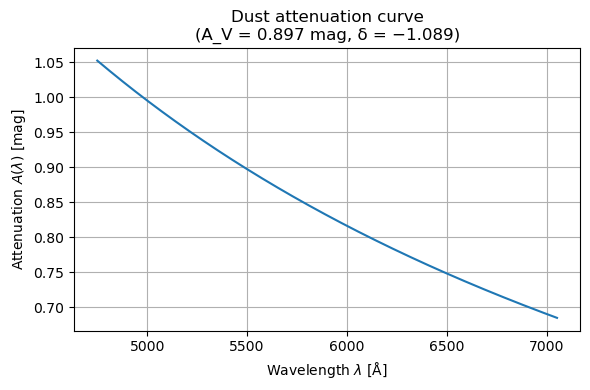

In [12]:
# Plot dust attenuation curve
# --- parameters from the pPXF fit
A_V = 0.897          # V‑band attenuation in magnitudes
delta = -1.089       # tilt of the curve

# --- wavelength grid (Å)
lam = np.linspace(4750, 7050, 600)   # 600 points between 4750 and 7050 Å

# --- simplified two‑parameter attenuation curve (Cappellari 2023)
#     A(λ) = A_V * (λ / 5500 Å)^δ
A_lambda = A_V * (lam / 5500.0)**delta

# --- plot -----------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(lam, A_lambda)
plt.xlabel(r"Wavelength $\lambda$ [Å]")
plt.ylabel(r"Attenuation $A(\lambda)$ [mag]")
plt.title("Dust attenuation curve\n(A_V = 0.897 mag, δ = −1.089)")
plt.grid(True)
plt.tight_layout()
plt.show()

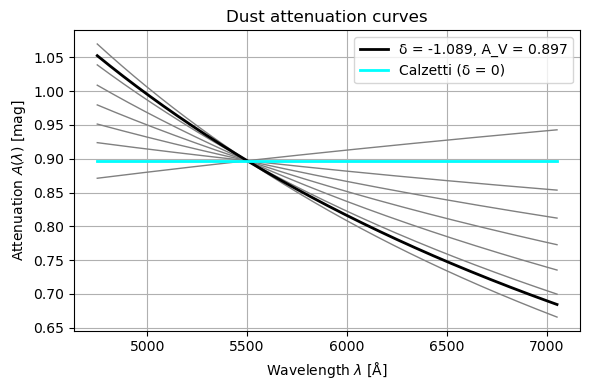

In [13]:
# wavelength grid
lam = np.linspace(4750, 7050, 600)

# fixed A_V for first family
A_V_fixed = 0.897

# deltas to show
deltas_gray = [0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -1.2]
delta_black = -1.089

# extra curve with different A_V and delta
A_V_extra = 1.653
delta_extra = 0.0

# plot
plt.figure(figsize=(6, 4))

# gray family
for d in deltas_gray:
    A_lambda = A_V_fixed * (lam / 5500.0) ** d
    plt.plot(lam, A_lambda, color='gray', linewidth=1)

# black line (fit result)
A_lambda_black = A_V_fixed * (lam / 5500.0) ** delta_black
plt.plot(lam, A_lambda_black, color='black', linewidth=2, label=f"δ = {delta_black:.3f}, A_V = {A_V_fixed}")

# cyan Calzetti (δ = 0)
A_lambda_cyan = A_V_fixed * (lam / 5500.0) ** 0.0
plt.plot(lam, A_lambda_cyan, color='cyan', linewidth=2, label="Calzetti (δ = 0)")

# # blue extra curve
# A_lambda_blue = A_V_extra * (lam / 5500.0) ** delta_extra
# plt.plot(lam, A_lambda_blue, color='blue', linewidth=2, label=f"δ = {delta_extra:.3f}, A_V = {A_V_extra}")

plt.xlabel(r"Wavelength $\lambda$ [Å]")
plt.ylabel(r"Attenuation $A(\lambda)$ [mag]")
plt.title("Dust attenuation curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


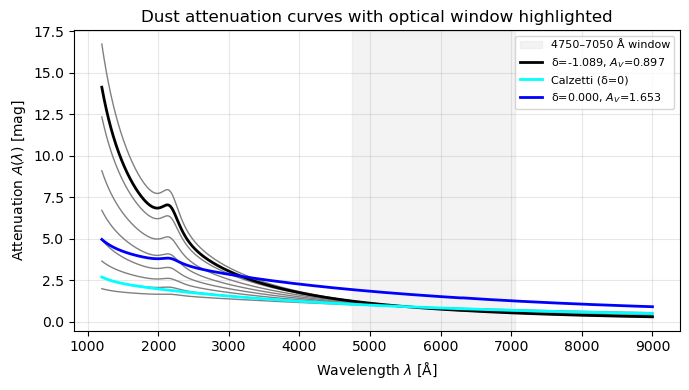

In [14]:
# -----------------------------------------------------------
# Calzetti baseline k'(λ)
def k_prime_calzetti(lam_micron, Rv=4.05):
    k = np.empty_like(lam_micron)
    mask_long  = (lam_micron >= 0.63) & (lam_micron <= 2.20)
    mask_short = (lam_micron >= 0.12) & (lam_micron < 0.63)
    k[mask_long]  = 2.659 * (-1.857 + 1.040 / lam_micron[mask_long]) + Rv
    k[mask_short] = 2.659 * (-2.156 + 1.509 / lam_micron[mask_short]
                             - 0.198 / lam_micron[mask_short]**2
                             + 0.011 / lam_micron[mask_short]**3) + Rv
    k[~(mask_long | mask_short)] = np.nan
    return k

# full law with tilt & optional bump
def attenuation(lam_ang, A_V, delta, Eb=None, Rv=4.05,
                lam0_bump=2175.0, dlam_bump=350.0):
    if Eb is None:
        Eb = 0.85 - 1.9 * delta   # KC13 correlation (only if user leaves Eb=None)
    lam_micron = lam_ang * 1e-4
    k_prime = k_prime_calzetti(lam_micron, Rv=Rv)
    D = Eb * (lam_ang * dlam_bump)**2 / (
        (lam_ang**2 - lam0_bump**2)**2 + (lam_ang * dlam_bump)**2
    )
    return (A_V / Rv) * (k_prime + D) * (lam_ang / 5500.0) ** delta

# -----------------------------------------------------------
lam = np.linspace(1000, 9000, 1000)  # Å

A_V_fixed   = 0.897
deltas_gray = [0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -1.2]
delta_black = -1.089
A_V_extra   = 1.653
delta_extra = 0.0

plt.figure(figsize=(7, 4))

# shaded optical window
plt.axvspan(4750, 7050, color='lightgray', alpha=0.25, zorder=0,
            label="4750–7050 Å window")

# gray family
for d in deltas_gray:
    plt.plot(lam, attenuation(lam, A_V_fixed, d),
             color='gray', linewidth=1, zorder=2)

# black fit result
plt.plot(lam, attenuation(lam, A_V_fixed, delta_black),
         color='black', linewidth=2, label=f"δ={delta_black:.3f}, $A_V$={A_V_fixed}")

# cyan Calzetti
plt.plot(lam, attenuation(lam, A_V_fixed, 0.0, Eb=0.0),
         color='cyan', linewidth=2, label="Calzetti (δ=0)")

# blue extra
plt.plot(lam, attenuation(lam, A_V_extra, delta_extra),
         color='blue', linewidth=2, label=f"δ={delta_extra:.3f}, $A_V$={A_V_extra}")

plt.xlabel(r"Wavelength $\lambda$ [Å]")
plt.ylabel(r"Attenuation $A(\lambda)$ [mag]")
plt.title("Dust attenuation curves with optical window highlighted")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


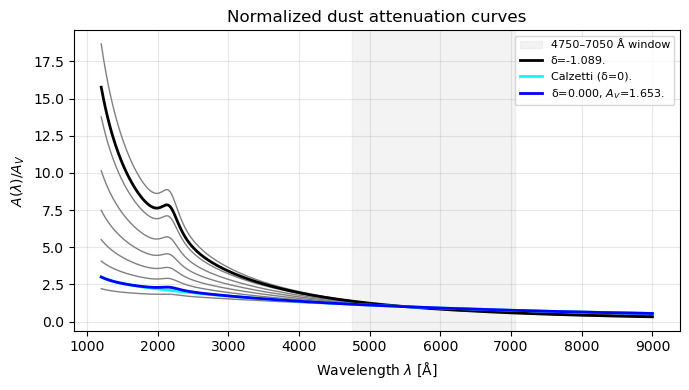

In [15]:
# -----------------------------------------------------------
# Calzetti baseline k'(λ)
def k_prime_calzetti(lam_micron, Rv=4.05):
    k = np.empty_like(lam_micron)
    mask_long  = (lam_micron >= 0.63) & (lam_micron <= 2.20)
    mask_short = (lam_micron >= 0.12) & (lam_micron < 0.63)
    k[mask_long]  = 2.659 * (-1.857 + 1.040 / lam_micron[mask_long]) + Rv
    k[mask_short] = 2.659 * (-2.156 + 1.509 / lam_micron[mask_short]
                             - 0.198 / lam_micron[mask_short]**2
                             + 0.011 / lam_micron[mask_short]**3) + Rv
    k[~(mask_long | mask_short)] = np.nan
    return k

# full law with tilt & optional bump
def attenuation(lam_ang, A_V, delta, Eb=None, Rv=4.05,
                lam0_bump=2175.0, dlam_bump=350.0):
    if Eb is None:
        Eb = 0.85 - 1.9 * delta   # KC13 correlation
    lam_micron = lam_ang * 1e-4
    k_prime = k_prime_calzetti(lam_micron, Rv=Rv)
    D = Eb * (lam_ang * dlam_bump)**2 / (
        (lam_ang**2 - lam0_bump**2)**2 + (lam_ang * dlam_bump)**2
    )
    return (A_V / Rv) * (k_prime + D) * (lam_ang / 5500.0) ** delta

# -----------------------------------------------------------
lam = np.linspace(1000, 9000, 1000)  # Å

A_V_fixed   = 0.897
deltas_gray = [0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -1.2]
delta_black = -1.089
A_V_extra   = 1.653
delta_extra = 0.0

plt.figure(figsize=(7, 4))

# shaded optical window
plt.axvspan(4750, 7050, color='lightgray', alpha=0.25, zorder=0,
            label="4750–7050 Å window")

# gray family
for d in deltas_gray:
    A_lam = attenuation(lam, A_V_fixed, d) / A_V_fixed  # normalize
    plt.plot(lam, A_lam, color='gray', linewidth=1)

# black normalized
plt.plot(lam, attenuation(lam, A_V_fixed, delta_black)/A_V_fixed,
         color='black', linewidth=2,
         label=f"δ={delta_black:.3f}.")

# cyan Calzetti
plt.plot(lam, attenuation(lam, A_V_fixed, 0.0, Eb=0.0)/A_V_fixed,
         color='cyan', linewidth=2, label="Calzetti (δ=0).")

# blue extra curve normalized by its own A_V
plt.plot(lam, attenuation(lam, A_V_extra, delta_extra)/A_V_extra,
         color='blue', linewidth=2, label=f"δ={delta_extra:.3f}, $A_V$={A_V_extra}.")

plt.xlabel(r"Wavelength $\lambda$ [Å]")
plt.ylabel(r"$A(\lambda)/A_V$")
plt.title("Normalized dust attenuation curves")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_34658/863817274.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


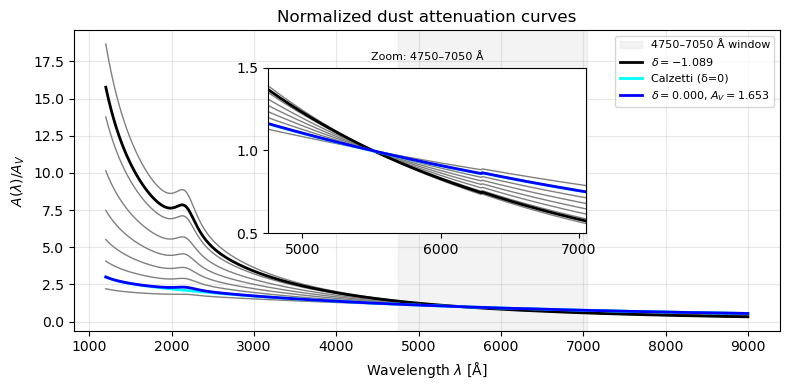

In [16]:
# -----------------------------------------------------------
def k_prime_calzetti(lam_micron, Rv=4.05):
    k = np.empty_like(lam_micron)
    mask_long  = (lam_micron >= 0.63) & (lam_micron <= 2.20)
    mask_short = (lam_micron >= 0.12) & (lam_micron < 0.63)
    k[mask_long]  = 2.659 * (-1.857 + 1.040 / lam_micron[mask_long]) + Rv
    k[mask_short] = 2.659 * (-2.156 + 1.509 / lam_micron[mask_short]
                             - 0.198 / lam_micron[mask_short]**2
                             + 0.011 / lam_micron[mask_short]**3) + Rv
    k[~(mask_long | mask_short)] = np.nan
    return k

def attenuation(lam_ang, A_V, delta, Eb=None, Rv=4.05,
                lam0_bump=2175.0, dlam_bump=350.0):
    if Eb is None:
        Eb = 0.85 - 1.9 * delta   # KC13 correlation
    lam_micron = lam_ang * 1e-4
    k_prime = k_prime_calzetti(lam_micron, Rv=Rv)
    D = Eb * (lam_ang * dlam_bump)**2 / (
        (lam_ang**2 - lam0_bump**2)**2 + (lam_ang * dlam_bump)**2
    )
    return (A_V / Rv) * (k_prime + D) * (lam_ang / 5500.0) ** delta

# -----------------------------------------------------------
lam = np.linspace(1000, 9000, 1000)  # Å

A_V_fixed   = 0.897
deltas_gray = [0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -1.2]
delta_black = -1.089
A_V_extra   = 1.653
delta_extra = 0.0

fig, ax = plt.subplots(figsize=(8, 4))

# shaded optical window
ax.axvspan(4750, 7050, color='lightgray', alpha=0.25, zorder=0,
           label="4750–7050 Å window")

# gray family
for d in deltas_gray:
    ax.plot(lam, attenuation(lam, A_V_fixed, d)/A_V_fixed,
            color='gray', linewidth=1)

# black normalized
ax.plot(lam, attenuation(lam, A_V_fixed, delta_black)/A_V_fixed,
        color='black', linewidth=2, label=fr"$\delta={delta_black:.3f}$")

# cyan Calzetti
ax.plot(lam, attenuation(lam, A_V_fixed, 0.0, Eb=0.0)/A_V_fixed,
        color='cyan', linewidth=2, label="Calzetti (δ=0)")

# blue extra curve normalized by its own A_V
ax.plot(lam, attenuation(lam, A_V_extra, delta_extra)/A_V_extra,
        color='blue', linewidth=2, label=fr"$\delta={delta_extra:.3f}$, $A_V={A_V_extra}$")

ax.set_xlabel(r"Wavelength $\lambda$ [Å]")
ax.set_ylabel(r"$A(\lambda)/A_V$")
ax.set_title("Normalized dust attenuation curves")

ax.grid(True, alpha=0.3)
ax.legend(fontsize=8, loc='upper right')

# -----------------------------------------------------------
# inset axes centred in the figure – give a 4-tuple anchor
axins = inset_axes(
    ax,
    width="45%", height="55%",       # relative to parent Axes
    loc='center',
    bbox_to_anchor=(0.0, 0.1, 1, 1), # (x0, y0, w, h) in Axes coords
    bbox_transform=ax.transAxes,
    borderpad=0.0
)

# plot same curves in zoom
for d in deltas_gray:
    axins.plot(lam, attenuation(lam, A_V_fixed, d)/A_V_fixed,
               color='gray', linewidth=1)

axins.plot(lam, attenuation(lam, A_V_fixed, delta_black)/A_V_fixed,
           color='black', linewidth=2)

axins.plot(lam, attenuation(lam, A_V_fixed, 0.0, Eb=0.0)/A_V_fixed,
           color='cyan', linewidth=2)

axins.plot(lam, attenuation(lam, A_V_extra, delta_extra)/A_V_extra,
           color='blue', linewidth=2)

# zoom limits
axins.set_xlim(4750, 7050)
y_zoom = attenuation(lam, A_V_fixed, delta_black)/A_V_fixed
mask_zoom = (lam >= 4750) & (lam <= 7050)
axins.set_ylim(y_zoom[mask_zoom].min()*0.97, y_zoom[mask_zoom].max()*1.03)

axins.set_xticks([5000, 6000, 7000])
axins.set_yticks([0.5, 1, 1.5])
axins.set_title("Zoom: 4750–7050 Å", fontsize=8)

plt.tight_layout()
plt.show()


In [17]:
# Check S/N ratio
snr = (log_flux[goodpixels] / log_noise[goodpixels])
print(f"Mean S/N ratio: {snr.mean():.1e} ± {snr.std():.1e}")
print(f"Median S/N ratio: {np.median(snr):.1e} ± {np.std(snr):.1e}")
print(f"Min S/N ratio: {snr.min():.1e} ± {snr.std():.1e}")
print(f"Max S/N ratio: {snr.max():.1e} ± {snr.std():.1e}")


Mean S/N ratio: 2.1e+03 ± 6.5e+02
Median S/N ratio: 2.1e+03 ± 6.5e+02
Min S/N ratio: 5.0e+02 ± 6.5e+02
Max S/N ratio: 3.6e+03 ± 6.5e+02


In [18]:
z_fit = pp.sol[0] / c_kms
print(f"Fitted redshift  : {z_fit:.5f}")
# # ---------- Composite M/L from pPXF weights ------------------------
weights = pp.weights.reshape(reg_dim)  / pp.weights.sum()    
ML_r = sps.mass_to_light(weights, band="DECam_r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

D = 11.5 * u.Mpc                                      # Virgo distance

from speclite import filters
f_r   = filters.load_filter('decamDR1-r')
lam_r = f_r.wavelength
R_r   = f_r.response

# best-fit continuum in erg s⁻¹ cm⁻² Å⁻¹
cont_flux = pp.bestfit * 1e-20 

#    cont_flux [erg s⁻¹ cm⁻² Å⁻¹] at instrument wavelengths range
flux_at_lam_r = np.interp(lam_r, log_lam, cont_flux)

# Compute the AB magnitude
m_r = f_r.get_ab_magnitude(
    flux_at_lam_r * u.erg / (u.cm**2 * u.s * u.AA),
    wavelength=lam_r
)

print(f"r-band apparent AB mag = {m_r:.2f}")

# Compute absolute magnitude
M_r = m_r - 5 * np.log10(D.to(u.pc).value / 10)

# Solar AB magnitude in r‐band
M_sun_r = ppxf_util.mag_sun(bands="DECam_r", redshift=z_fit, system="AB")[0]

# Luminosity in solar units
L_r_sun = 10**(-0.4 * (M_r - M_sun_r))
print(f"Absolute M_r = {M_r:.2f}, M_sun,r = {M_sun_r:.2f}")
print(f"r-band luminosity = {L_r_sun:.3e} L_sun = log({np.log10(L_r_sun):.3f} L☉)")

# If you want the physical luminosity in erg/s:
L_r = L_r_sun * c.L_sun
print(f"r-band luminosity = {L_r:.3e}")

# Given that we know the mass-to-light ratio, we can compute the stellar mass
M_star = ML_r * L_r_sun
print(f"Log M_star        : log({np.log10(M_star):.3f}  M☉)")

Fitted redshift  : 0.00559
(M*/L)=2.073 (DECam_r at z=0.0056)
M/L (r band)  : 2.073  M☉/L☉ = log(0.317  M☉/L☉)
r-band apparent AB mag = 12.09
Absolute M_r = -18.22, M_sun,r = 4.62
r-band luminosity = 1.361e+09 L_sun = log(9.134 L☉)
r-band luminosity = 5.210e+35 W
Log M_star        : log(9.451  M☉)


In [19]:
z_fit = pp.sol[0] / c_kms
print(f"Fitted redshift  : {z_fit:.5f}")
# # ---------- Composite M/L from pPXF weights ------------------------
weights = pp.weights.reshape(reg_dim)  / pp.weights.sum()    
ML_r = sps.mass_to_light(weights, band="SDSS/r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

D = 11.5 * u.Mpc                                      # Virgo distance

from speclite import filters
f_r   = filters.load_filter('sdss2010noatm-r')
lam_r = f_r.wavelength
R_r   = f_r.response

# best-fit continuum in erg s⁻¹ cm⁻² Å⁻¹
cont_flux = pp.bestfit * 1e-20 

#    cont_flux [erg s⁻¹ cm⁻² Å⁻¹] at instrument wavelengths range
flux_at_lam_r = np.interp(lam_r, log_lam, cont_flux)

# Compute the AB magnitude
m_r = f_r.get_ab_magnitude(
    flux_at_lam_r * u.erg / (u.cm**2 * u.s * u.AA),
    wavelength=lam_r
)

print(f"r-band apparent AB mag = {m_r:.2f}")

# Compute absolute magnitude
M_r = m_r - 5 * np.log10(D.to(u.pc).value / 10)

# Solar AB magnitude in r‐band
M_sun_r = ppxf_util.mag_sun(bands="SDSS/r", redshift=z_fit, system="AB")[0]

# Luminosity in solar units
L_r_sun = 10**(-0.4 * (M_r - M_sun_r))
print(f"Absolute M_r = {M_r:.2f}, M_sun,r = {M_sun_r:.2f}")
print(f"r-band luminosity = {L_r_sun:.3e} L_sun = log({np.log10(L_r_sun):.3f} L☉)")

# If you want the physical luminosity in erg/s:
L_r = L_r_sun * c.L_sun
print(f"r-band luminosity = {L_r:.3e}")

# Given that we know the mass-to-light ratio, we can compute the stellar mass
M_star = ML_r * L_r_sun
print(f"Log M_star        : log({np.log10(M_star):.3f}  M☉)")

Fitted redshift  : 0.00559
(M*/L)=2.105 (SDSS/r at z=0.0056)
M/L (r band)  : 2.105  M☉/L☉ = log(0.323  M☉/L☉)
r-band apparent AB mag = 12.17
Absolute M_r = -18.13, M_sun,r = 4.65
r-band luminosity = 1.292e+09 L_sun = log(9.111 L☉)
r-band luminosity = 4.944e+35 W
Log M_star        : log(9.434  M☉)


In [20]:
z_fit = pp.sol[0] / c_kms
print(f"Fitted redshift  : {z_fit:.5f}")
# # ---------- Composite M/L from pPXF weights ------------------------
weights = pp.weights.reshape(reg_dim) / pp.weights.sum()    
ML_r = sps.mass_to_light(weights, band="SDSS/r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

D = 11.5 * u.Mpc           # Virgo distance

# 0) r-band data
lam  = lam_ang * u.angstrom
F_λ  = flux_sum * 1e-20 * u.erg/u.s/u.cm**2/u.angstrom
mask_r = (lam_ang> 5400) & (lam_ang < 7000)
lam_r = lam[mask_r]

F_λ_r = F_λ[mask_r]

# 1) Convert to Fν
F_ν = (F_λ_r * lam_r**2 / c.c).to(u.erg/u.s/u.cm**2/u.Hz)

# 2) Sort and integrate over ν
ν = (c.c / lam_r).to(u.Hz)
idx = np.argsort(ν)
ν_sorted, Fν_sorted = ν[idx], F_ν[idx]

Fν_int = np.trapezoid(Fν_sorted, ν_sorted)
Δν     = ν_sorted.max() - ν_sorted.min()
Fν_avg = Fν_int / Δν

# 3) AB zero-point
Fν0 = (3631 * u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)

# 4) AB magnitude
m_r = -2.5 * np.log10(Fν_avg / Fν0)
print(f"AB apparent magnitude = {m_r:.3f}")

# 5) Compute absolute magnitude
M_r = m_r - 5 * np.log10(D.to(u.pc).value / 10)

# 6) Solar AB magnitude in r‐band
M_sun_r = ppxf_util.mag_sun(bands="SDSS/r", redshift=z_fit, system="AB")[0]

# 7) Luminosity in solar units
L_r_sun = 10**(-0.4 * (M_r - M_sun_r))
print(f"Absolute M_r = {M_r:.2f}, M_sun,r = {M_sun_r:.2f}")
print(f"r-band luminosity = {L_r_sun:.3e} L_sun = log({np.log10(L_r_sun):.3f} L☉)")

# 8) Get the physical luminosity in erg/s:
L_r = L_r_sun * c.L_sun
print(f"r-band luminosity = {L_r:.3e}")

# 9) Given that we know the mass-to-light ratio, we can compute the stellar mass
M_star = ML_r * L_r_sun
print(f"Log M_star        : log({np.log10(M_star):.3f}  M☉)")

Fitted redshift  : 0.00559
(M*/L)=2.105 (SDSS/r at z=0.0056)
M/L (r band)  : 2.105  M☉/L☉ = log(0.323  M☉/L☉)
AB apparent magnitude = 12.369
Absolute M_r = -17.93, M_sun,r = 4.65
r-band luminosity = 1.077e+09 L_sun = log(9.032 L☉)
r-band luminosity = 4.121e+35 W
Log M_star        : log(9.355  M☉)


In [21]:
ppxf_util.mag_sun(bands="SDSS/g", redshift=0, system="AB")[0]

np.float64(5.122704124098617)

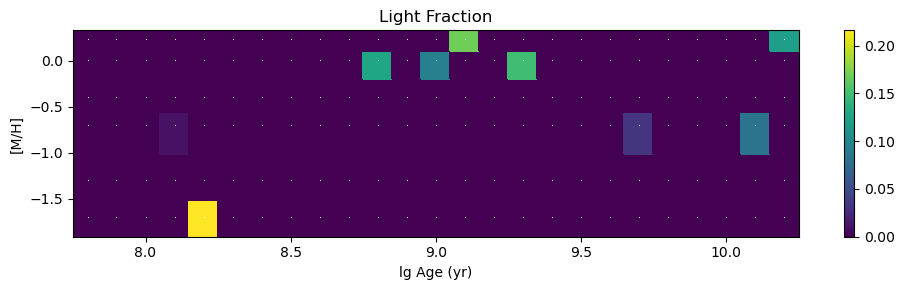

In [22]:
plt.figure(figsize=(10,3))
sps.plot(weights)
plt.title("Light Fraction")
plt.tight_layout()
plt.show()

In [23]:
weights[weights > 0]

array([0.00984427, 0.21608578, 0.12765692, 0.0930741 , 0.16858939,
       0.1495281 , 0.03328303, 0.08195933, 0.11997908])

In [24]:
# assume z_fit, weights (25×6), and sps are defined

ml_each = np.zeros_like(weights, dtype=float)

# get (row, col) pairs where weight > 0
ij_idx = np.argwhere(weights > 0)                  # shape=(133, 2)

for (i, j) in ij_idx:
    # one‐hot selector for template (i,j)
    w_ij = np.zeros_like(weights)
    w_ij[i, j] = 1.0

    # compute M/L and extract scalar
    ml_each[i, j] = float(np.atleast_1d(
        sps.mass_to_light(w_ij, band="DECam_r", redshift=z_fit)
    )[0])

# now print
print("M/L per template (only where weight > 0):")
for (i, j) in ij_idx:
    print(f"  template ({i},{j}): weight = {weights[i,j]:.3f}, "
          f"M/L = {ml_each[i,j]:.3f} M☉/L☉")


(M*/L)=0.1659 (DECam_r at z=0.0056)
(M*/L)=0.1351 (DECam_r at z=0.0056)
(M*/L)=0.6521 (DECam_r at z=0.0056)
(M*/L)=0.8855 (DECam_r at z=0.0056)
(M*/L)=1.123 (DECam_r at z=0.0056)
(M*/L)=1.487 (DECam_r at z=0.0056)
(M*/L)=1.911 (DECam_r at z=0.0056)
(M*/L)=3.714 (DECam_r at z=0.0056)
(M*/L)=8.026 (DECam_r at z=0.0056)
M/L per template (only where weight > 0):
  template (3,2): weight = 0.010, M/L = 0.166 M☉/L☉
  template (4,0): weight = 0.216, M/L = 0.135 M☉/L☉
  template (10,4): weight = 0.128, M/L = 0.652 M☉/L☉
  template (12,4): weight = 0.093, M/L = 0.886 M☉/L☉
  template (13,5): weight = 0.169, M/L = 1.123 M☉/L☉
  template (15,4): weight = 0.150, M/L = 1.487 M☉/L☉
  template (19,2): weight = 0.033, M/L = 1.911 M☉/L☉
  template (23,2): weight = 0.082, M/L = 3.714 M☉/L☉
  template (24,5): weight = 0.120, M/L = 8.026 M☉/L☉


In [25]:
len(weights[weights>0])

9

In [26]:
sps.mass_to_light(pp.weights.reshape(reg_dim), band="SDSS/r", redshift=z_fit,) 

(M*/L)=2.105 (SDSS/r at z=0.0056)


np.float64(2.105115886432864)

In [27]:
sps.mass_to_light(pp.weights.reshape(reg_dim)/pp.weights.sum(), band="SDSS/r", redshift=z_fit,) 

(M*/L)=2.105 (SDSS/r at z=0.0056)


np.float64(2.1051158864328645)

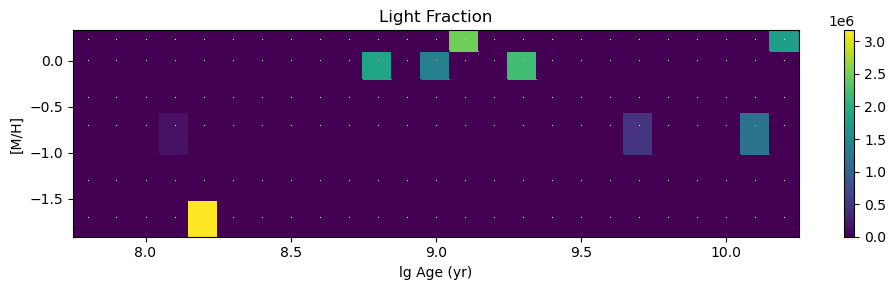

In [28]:
plt.figure(figsize=(10,3))
sps.plot(pp.weights.reshape(reg_dim))
plt.title("Light Fraction")
plt.tight_layout()
plt.show()

In [29]:
lam_r.shape

(1279,)

In [30]:
np.trapezoid(log_flux, np.e**log_lam) # 10**-20 cm-2 erg s-1

np.float64(7680149247.387754)

In [31]:
(np.trapezoid(flux_sum, lam_ang)*1e-20*u.erg/u.s*(4*np.pi*D**2)/u.cm**2).to(u.W)/c.L_sun # cm-2 

<Quantity 3.02982654e+08>

In [32]:
(np.dot(flux_sum, lam_ang)*1e-20*u.erg/u.s*(4*np.pi*D**2)/u.cm**2).to(u.W)/c.L_sun

<Quantity 1.43316615e+12>

In [33]:
sps.mean_age_metal(weights)

Weighted <lg_age> [yr]: 9.11
Weighted <[M/H]>: -0.395


(np.float64(9.111895980529003), np.float64(-0.39483312469507825))

In [34]:
sps.mass_to_light(weights, band="DECam_", redshift=z_fit,) 

(M*/L)=1.768 (DECam_ at z=0.0056)


np.float64(1.7677914996046045)

In [35]:
sps.mass_to_light(weights, band="DECam_g", redshift=z_fit,) 

(M*/L)=2.083 (DECam_g at z=0.0056)


np.float64(2.0826773751734153)

In [36]:
sps.mass_to_light(weights, band="DECam_i", redshift=z_fit,) 

(M*/L)=1.813 (DECam_i at z=0.0056)


np.float64(1.8130184100635054)

In [37]:
sps.mass_to_light(weights, band="SDSS/i", redshift=z_fit,) 

(M*/L)=1.867 (SDSS/i at z=0.0056)


np.float64(1.867435479737548)

In [38]:
ppxf_util.mag_sun(bands="SDSS/r", redshift=z_fit, system = "AB") 

array([4.64580546])

 Best Fit:       Vel     sigma
 comp.  0:      1675        65
Attenuation Parameters 0: 1.653 0.000
chi2/DOF: 834.0; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 9/150
(M*/L)=2.105 (SDSS/r at z=0.0056)
dust   | regul=    0 | χ²/DOF= 834.00 | M/L_r=  2.11 = log( 0.323) | 


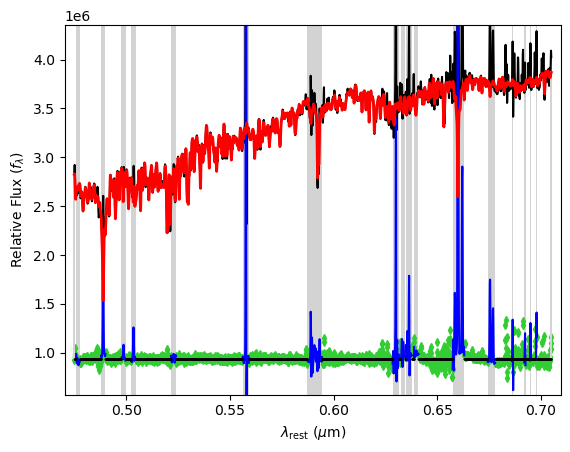

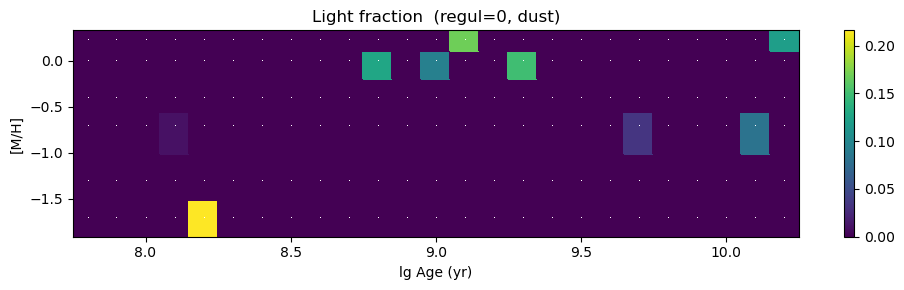

 Best Fit:       Vel     sigma
 comp.  0:      1675        65
Attenuation Parameters 0: 1.653 0.000
chi2/DOF: 834.0; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 9/150
(M*/L)=2.112 (SDSS/r at z=0.0056)
dust   | regul=1e-06 | χ²/DOF= 834.01 | M/L_r=  2.11 = log( 0.325) | 


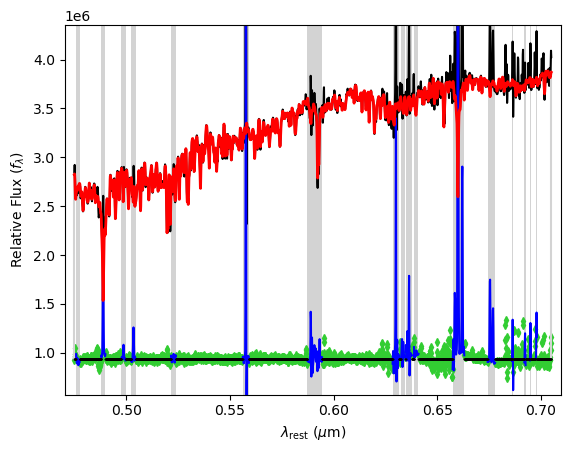

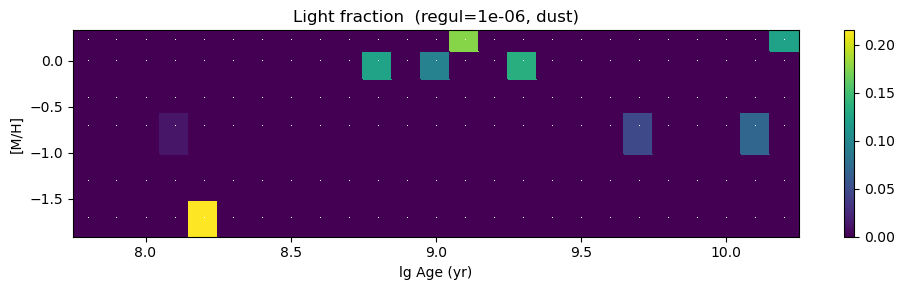

 Best Fit:       Vel     sigma
 comp.  0:      1675        65
Attenuation Parameters 0: 1.627 0.000
chi2/DOF: 835.8; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 36/150
(M*/L)=2.045 (SDSS/r at z=0.0056)
dust   | regul=1e-05 | χ²/DOF= 835.84 | M/L_r=  2.05 = log( 0.311) | 


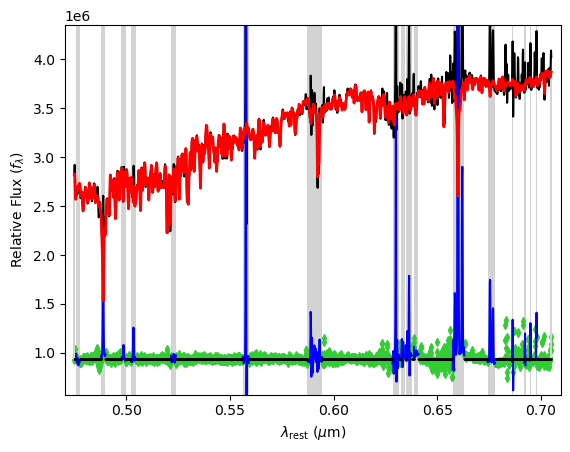

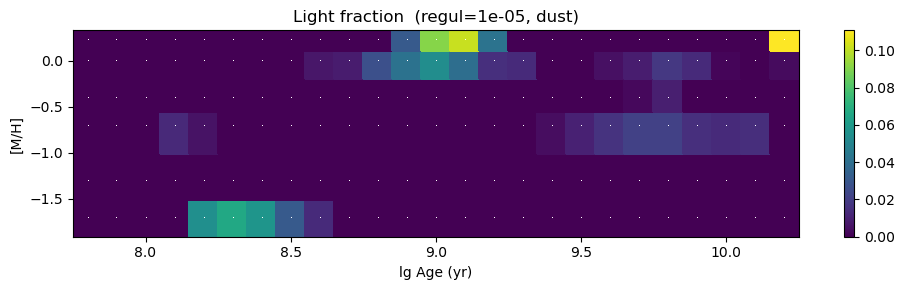

 Best Fit:       Vel     sigma
 comp.  0:      1676        64
Attenuation Parameters 0: 1.603 0.000
chi2/DOF: 842.5; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 77/150
(M*/L)=2.047 (SDSS/r at z=0.0056)
dust   | regul=0.0001 | χ²/DOF= 842.53 | M/L_r=  2.05 = log( 0.311) | 


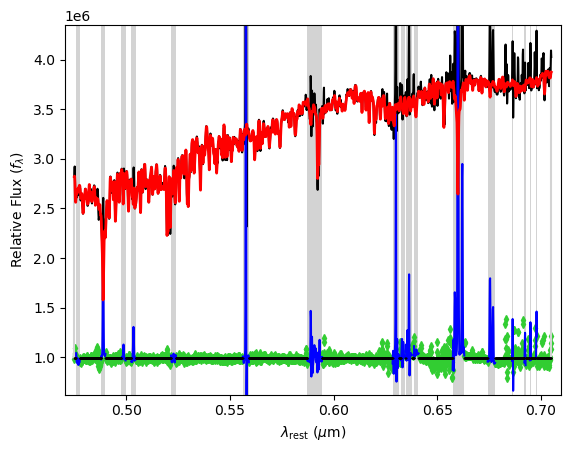

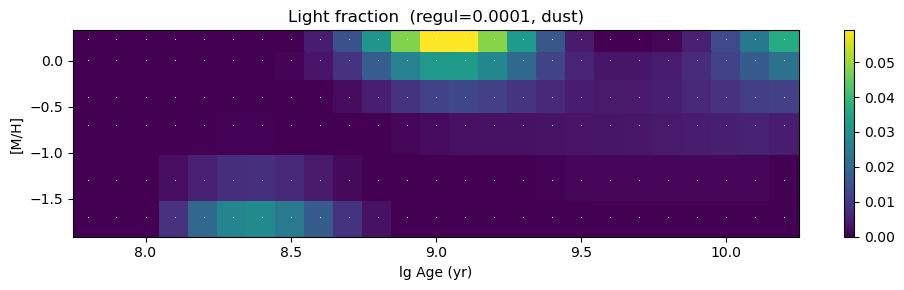

 Best Fit:       Vel     sigma
 comp.  0:      1676        62
Attenuation Parameters 0: 1.557 0.000
chi2/DOF: 852.2; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 93/150
(M*/L)=1.814 (SDSS/r at z=0.0056)
dust   | regul=0.001 | χ²/DOF= 852.17 | M/L_r=  1.81 = log( 0.259) | 


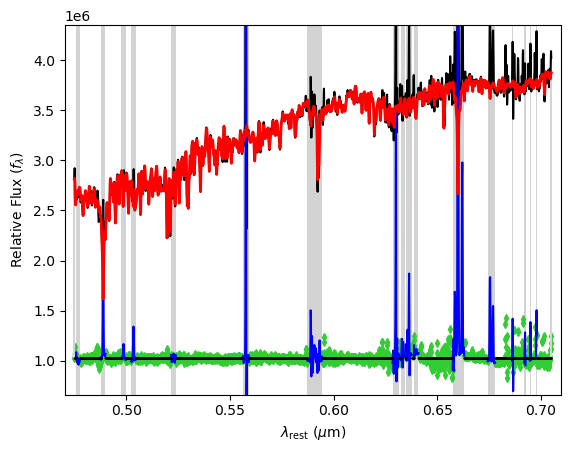

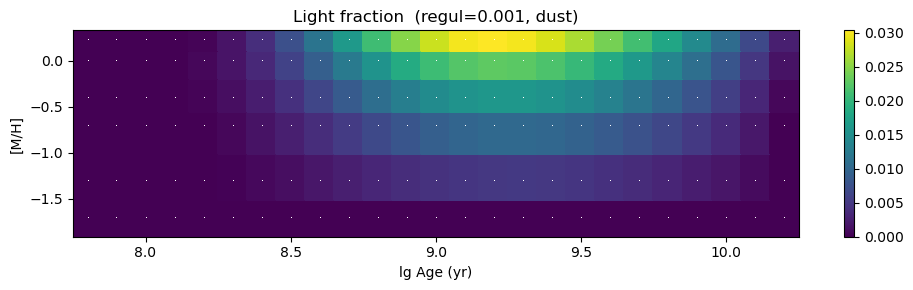

 Best Fit:       Vel     sigma
 comp.  0:      1676        61
Attenuation Parameters 0: 1.452 0.000
chi2/DOF: 859.9; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 115/150
(M*/L)=2.312 (SDSS/r at z=0.0056)
dust   | regul= 0.01 | χ²/DOF= 859.91 | M/L_r=  2.31 = log( 0.364) | 


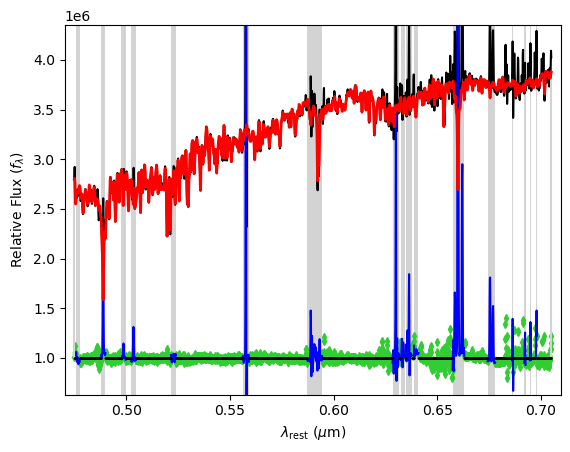

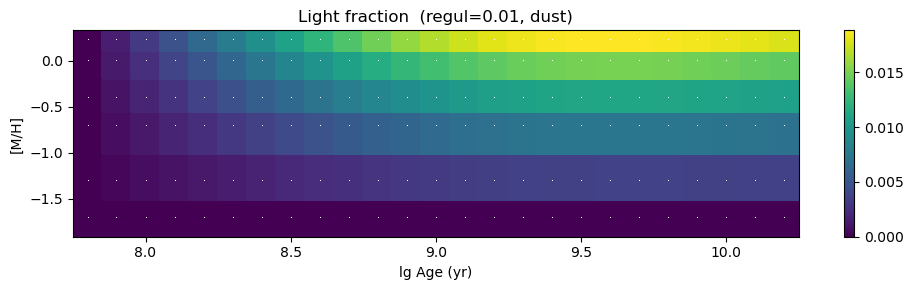

 Best Fit:       Vel     sigma
 comp.  0:      1676        61
Attenuation Parameters 0: 1.394 0.000
chi2/DOF: 864.2; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 124/150
(M*/L)=2.454 (SDSS/r at z=0.0056)
dust   | regul=  0.1 | χ²/DOF= 864.22 | M/L_r=  2.45 = log( 0.390) | 


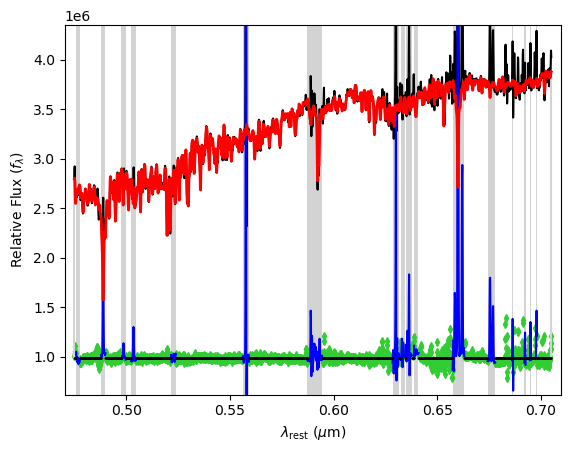

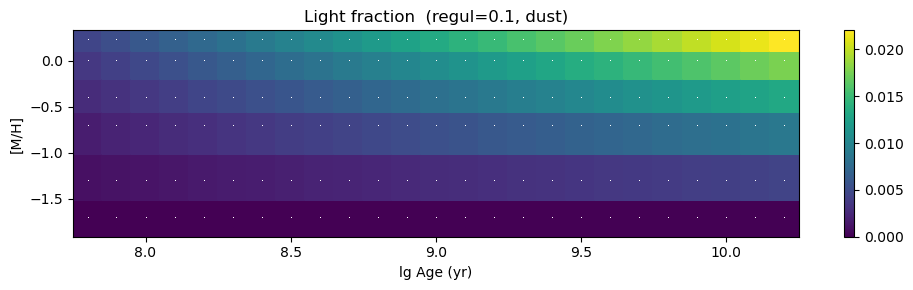

 Best Fit:       Vel     sigma
 comp.  0:      1676        61
Attenuation Parameters 0: 1.395 0.000
chi2/DOF: 864.3; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 124/150
(M*/L)=2.455 (SDSS/r at z=0.0056)
dust   | regul=    1 | χ²/DOF= 864.31 | M/L_r=  2.46 = log( 0.390) | 


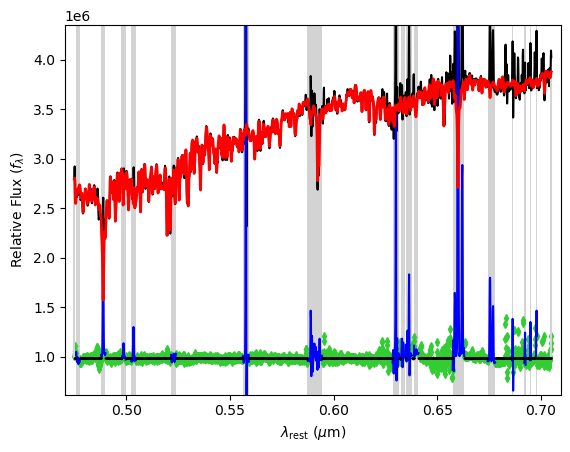

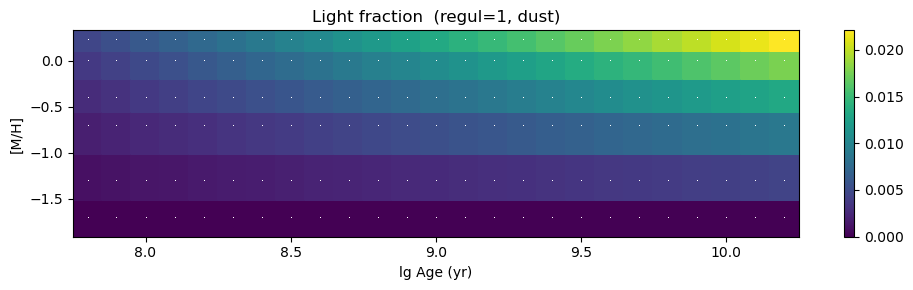

 Best Fit:       Vel     sigma
 comp.  0:      1676        61
Attenuation Parameters 0: 1.394 0.000
chi2/DOF: 864.3; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 124/150
(M*/L)=2.455 (SDSS/r at z=0.0056)
dust   | regul=   10 | χ²/DOF= 864.31 | M/L_r=  2.46 = log( 0.390) | 


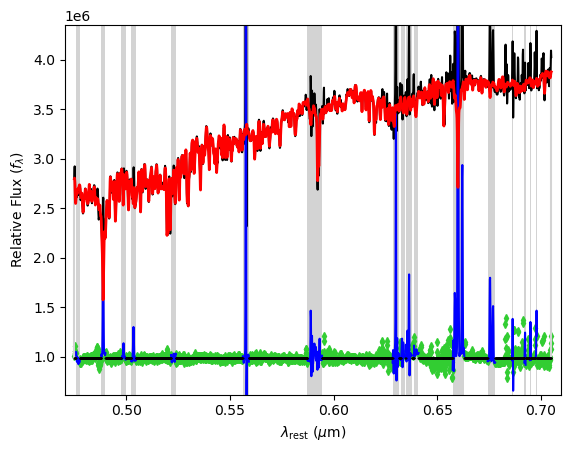

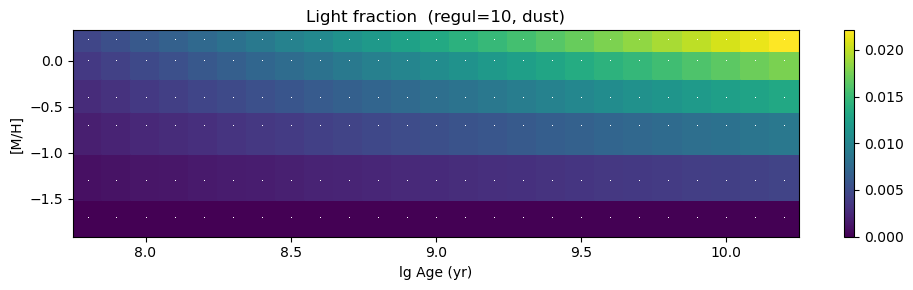

 Best Fit:       Vel     sigma
 comp.  0:      1676        61
Attenuation Parameters 0: 1.395 0.000
chi2/DOF: 864.3; DOF: 1831; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 124/150
(M*/L)=2.455 (SDSS/r at z=0.0056)
dust   | regul=  100 | χ²/DOF= 864.31 | M/L_r=  2.46 = log( 0.390) | 


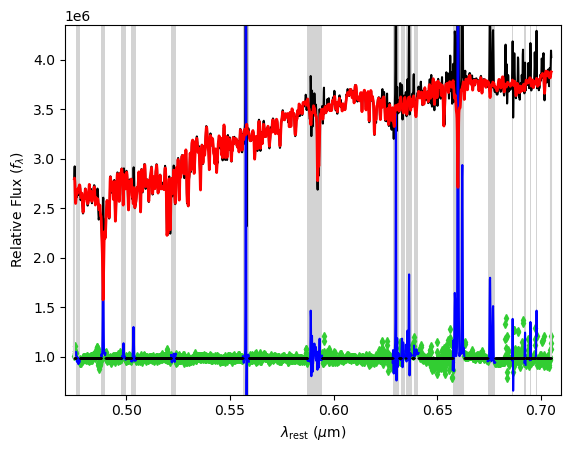

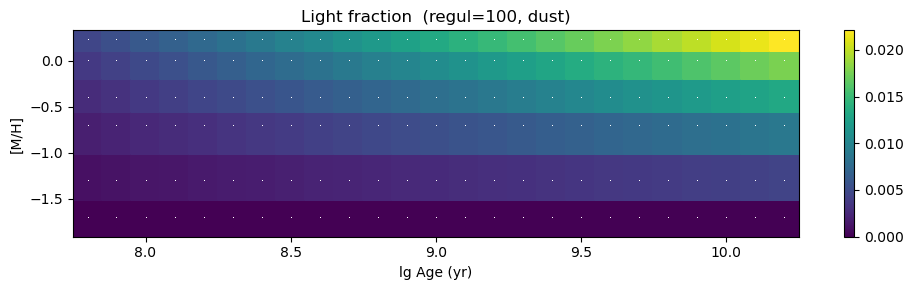

 Best Fit:       Vel     sigma
 comp.  0:      1675        59
chi2/DOF: 888.9; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
(M*/L)=2.139 (SDSS/r at z=0.0056)
nodust | regul=    0 | χ²/DOF= 888.87 | M/L_r=  2.14 = log( 0.330) | 


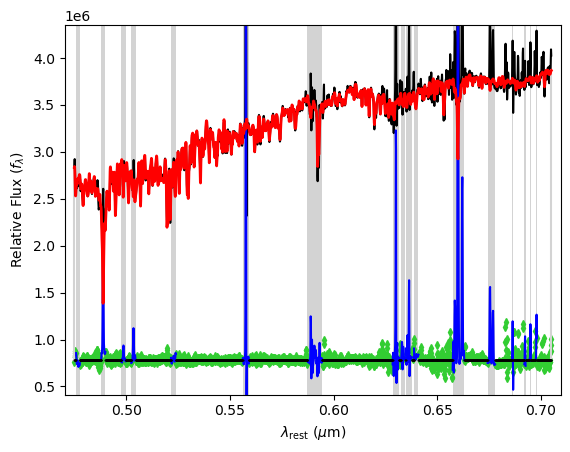

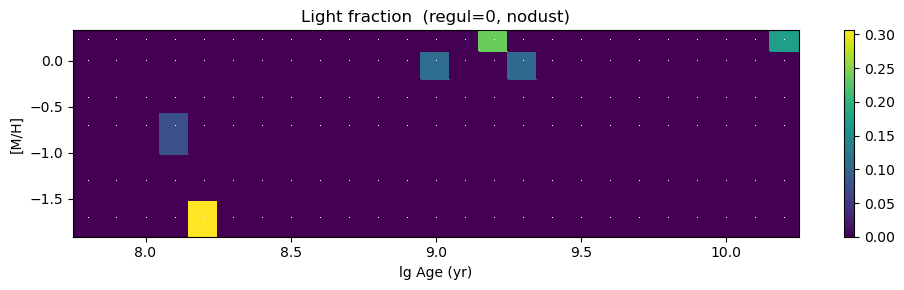

 Best Fit:       Vel     sigma
 comp.  0:      1675        59
chi2/DOF: 888.9; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
(M*/L)=2.140 (SDSS/r at z=0.0056)
nodust | regul=1e-06 | χ²/DOF= 888.87 | M/L_r=  2.14 = log( 0.330) | 


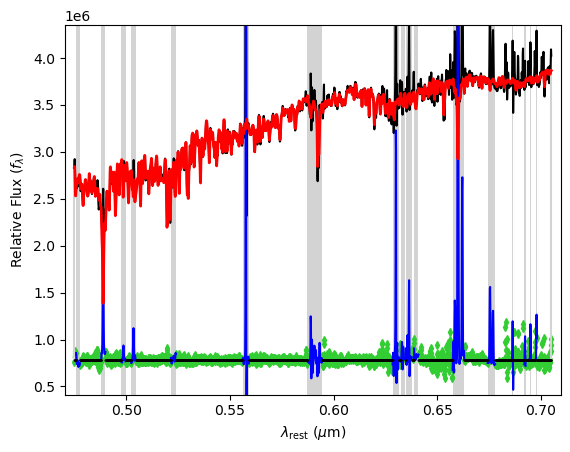

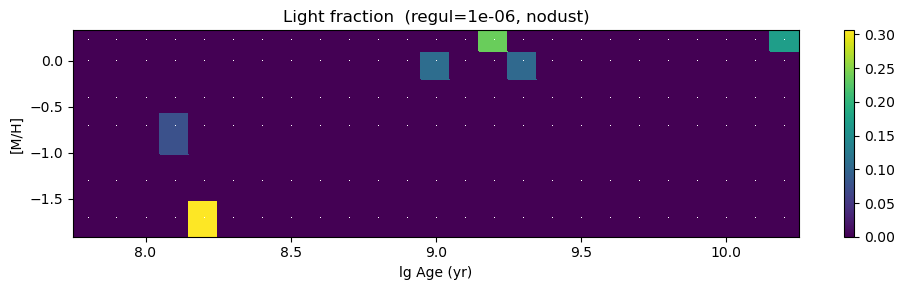

 Best Fit:       Vel     sigma
 comp.  0:      1675        59
chi2/DOF: 889.0; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 10/150
(M*/L)=2.167 (SDSS/r at z=0.0056)
nodust | regul=1e-05 | χ²/DOF= 889.03 | M/L_r=  2.17 = log( 0.336) | 


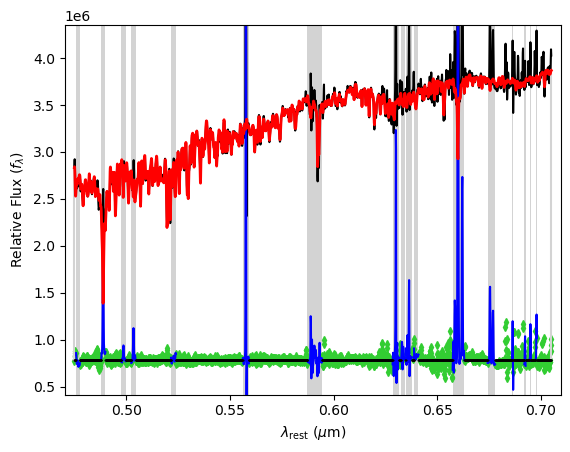

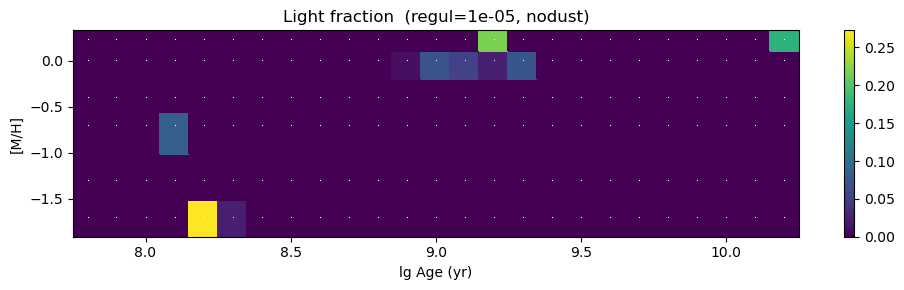

 Best Fit:       Vel     sigma
 comp.  0:      1675        59
chi2/DOF: 894.1; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 33/150
(M*/L)=2.102 (SDSS/r at z=0.0056)
nodust | regul=0.0001 | χ²/DOF= 894.06 | M/L_r=  2.10 = log( 0.323) | 


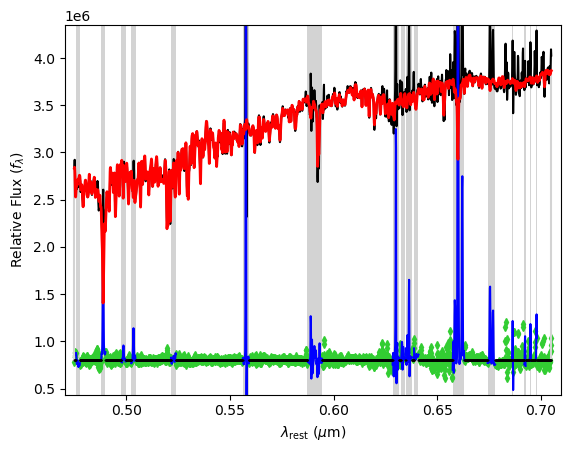

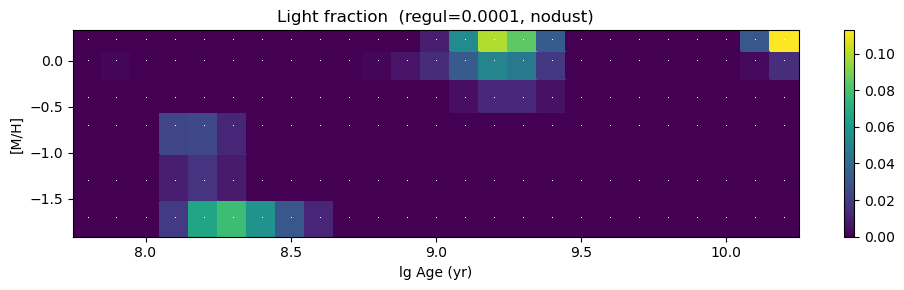

 Best Fit:       Vel     sigma
 comp.  0:      1675        58
chi2/DOF: 905.0; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 102/150
(M*/L)=2.005 (SDSS/r at z=0.0056)
nodust | regul=0.001 | χ²/DOF= 905.04 | M/L_r=  2.01 = log( 0.302) | 


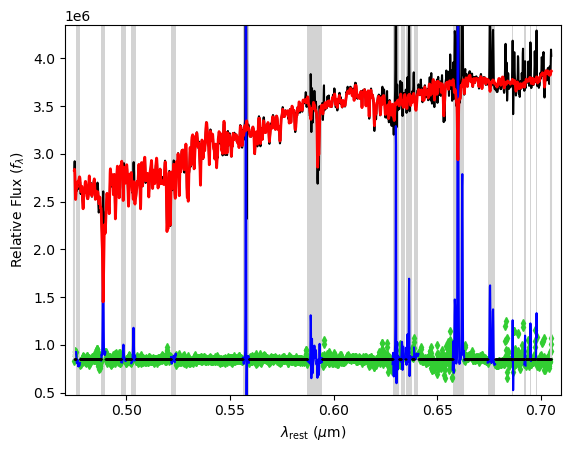

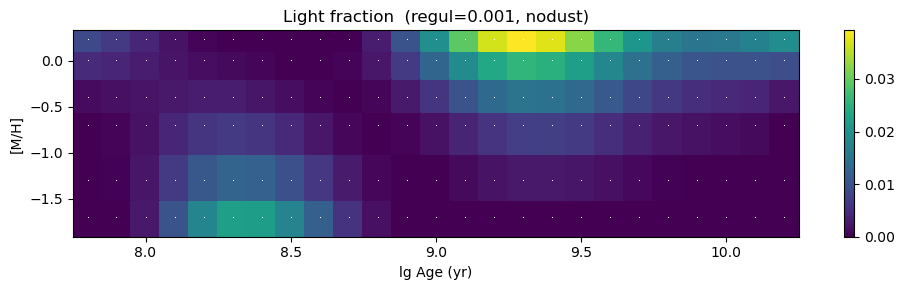

 Best Fit:       Vel     sigma
 comp.  0:      1675        57
chi2/DOF: 913.2; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 126/150
(M*/L)=2.475 (SDSS/r at z=0.0056)
nodust | regul= 0.01 | χ²/DOF= 913.21 | M/L_r=  2.48 = log( 0.394) | 


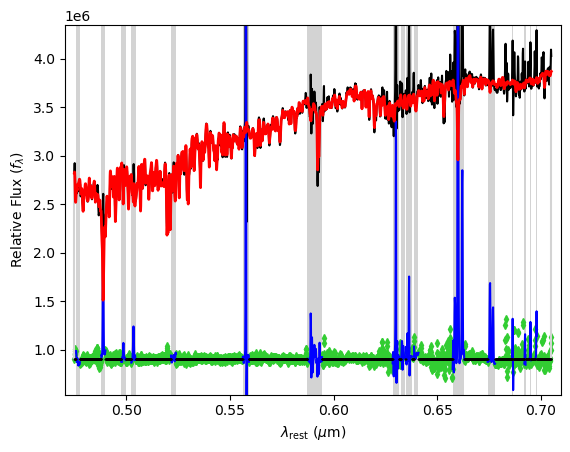

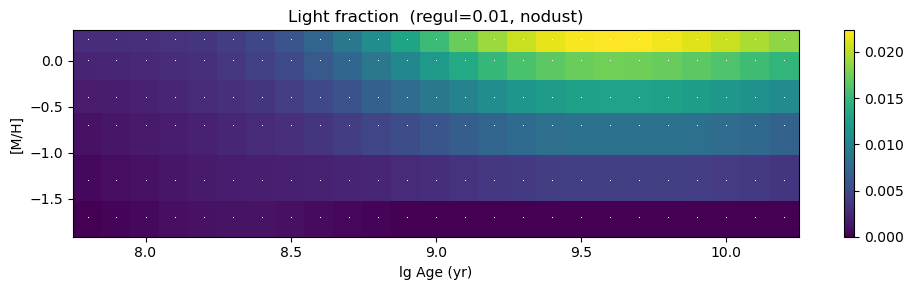

 Best Fit:       Vel     sigma
 comp.  0:      1675        57
chi2/DOF: 914.9; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 118/150
(M*/L)=2.676 (SDSS/r at z=0.0056)
nodust | regul=  0.1 | χ²/DOF= 914.87 | M/L_r=  2.68 = log( 0.427) | 


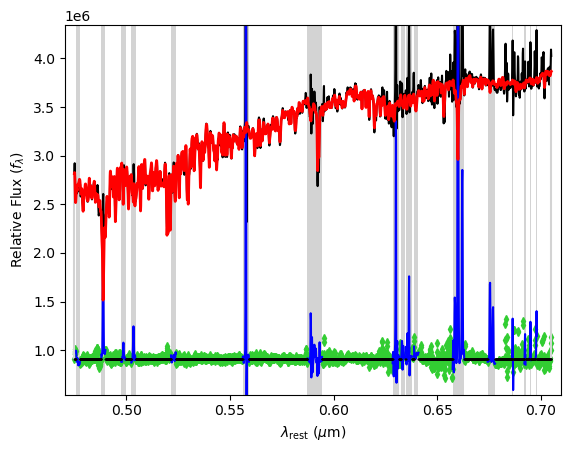

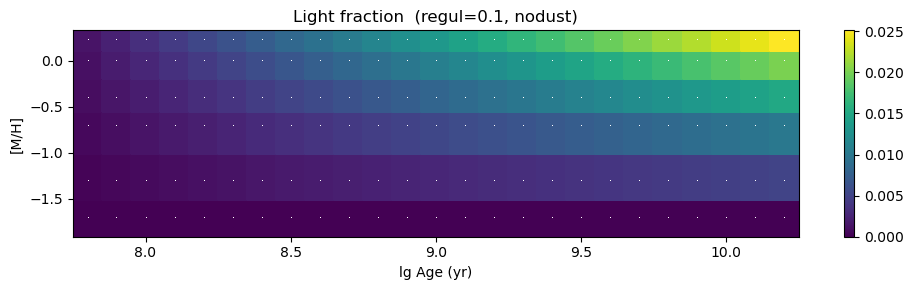

 Best Fit:       Vel     sigma
 comp.  0:      1675        57
chi2/DOF: 914.9; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 118/150
(M*/L)=2.680 (SDSS/r at z=0.0056)
nodust | regul=    1 | χ²/DOF= 914.91 | M/L_r=  2.68 = log( 0.428) | 


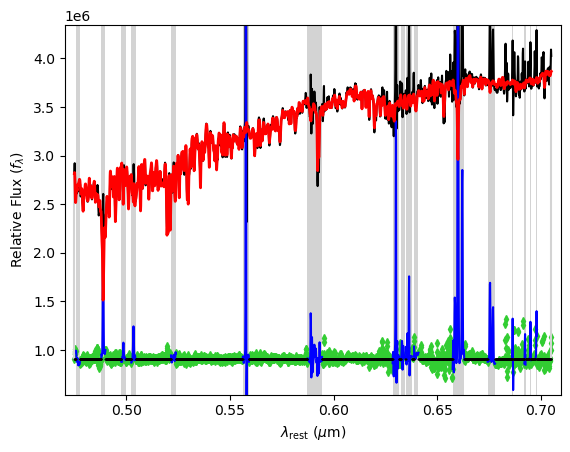

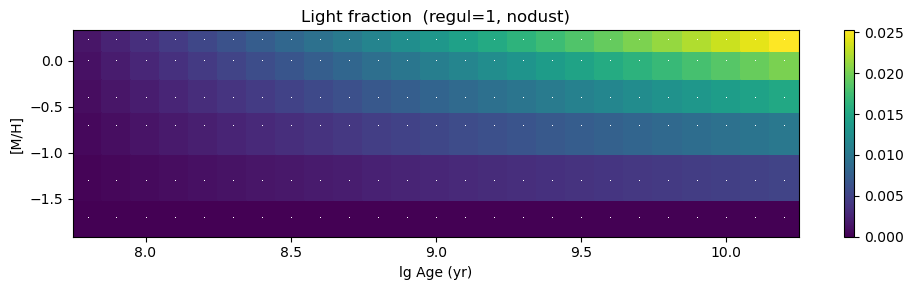

 Best Fit:       Vel     sigma
 comp.  0:      1675        57
chi2/DOF: 914.9; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 118/150
(M*/L)=2.680 (SDSS/r at z=0.0056)
nodust | regul=   10 | χ²/DOF= 914.91 | M/L_r=  2.68 = log( 0.428) | 


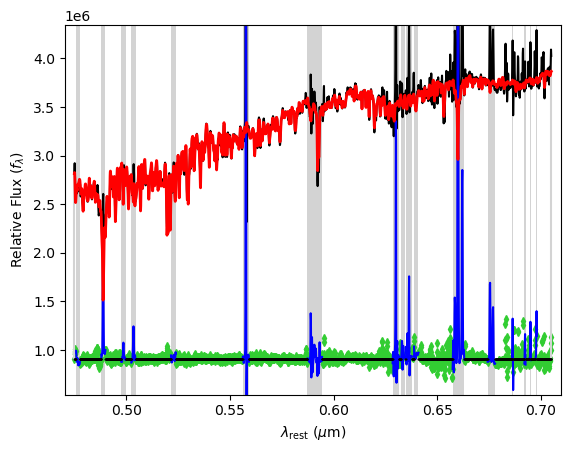

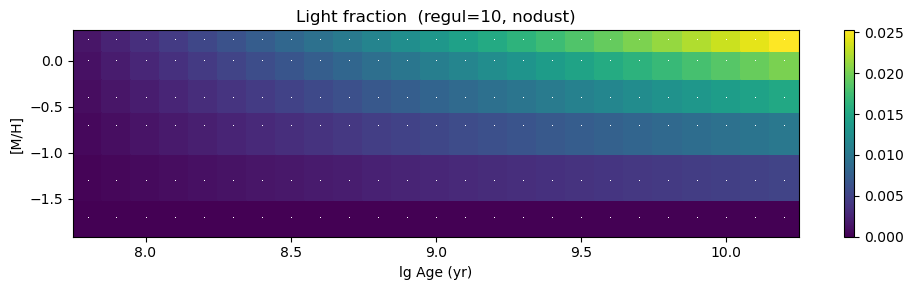

 Best Fit:       Vel     sigma
 comp.  0:      1675        57
chi2/DOF: 914.9; DOF: 1833; degree = 12; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 118/150
(M*/L)=2.680 (SDSS/r at z=0.0056)
nodust | regul=  100 | χ²/DOF= 914.91 | M/L_r=  2.68 = log( 0.428) | 


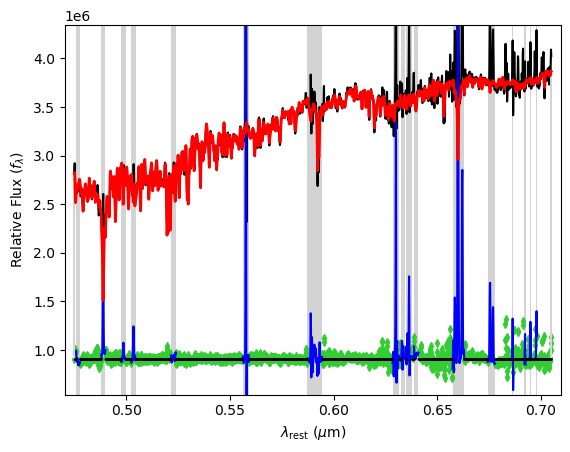

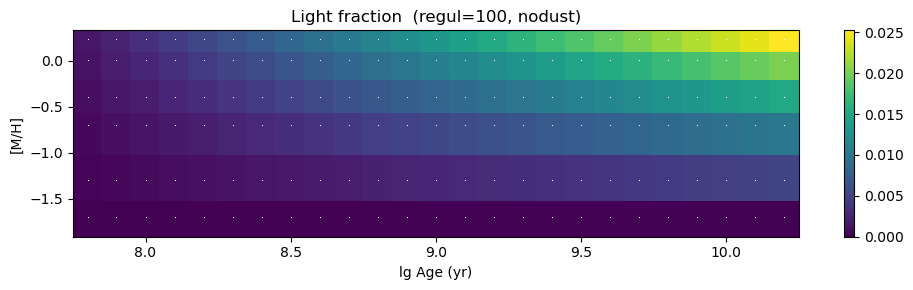

In [39]:
# -------------------------------------------------------------------
# penalty strengths to scan
regul_grid = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

# flag list: True  → use dust_stars ;  False → no dust
dust_toggle = [True, False]

for use_dust in dust_toggle:
    dust_label = "dust" if use_dust else "nodust"
    current_dust = [dust_stars] if use_dust else []   # what pPXF will see

    for rg in regul_grid:
        # -------- run pPXF -----------------------------------------
        pp = ppxf.ppxf(
            templates   = stars_templates,
            galaxy      = log_flux,
            noise       = log_noise,
            velscale    = velscale_out,
            start       = [start_V, start_sig],
            degree      = 12,
            mdegree     = 0,
            moments     = 2,
            goodpixels  = goodpixels,
            lam         = np.exp(log_lam),
            lam_temp    = sps.lam_temp,
            regul       = rg,
            reg_dim     = reg_dim,
            dust        = current_dust,     # <-- toggled
            plot        = False,
            # quiet       = True
        )

        # -------- (1) pPXF diagnostic panel ------------------------
        fig_fit = pp.plot()
        # fig_fit.suptitle(f"regul={rg:g}   ({dust_label})", fontsize=14)

        # -------- (2) light-fraction bar plot ----------------------
        w_norm = pp.weights.reshape(reg_dim)
        w_norm = w_norm / w_norm.sum()

        fig_lf, ax = plt.subplots(figsize=(10, 3))
        sps.plot(w_norm)
        ax.set_title(f"Light fraction  (regul={rg:g}, {dust_label})")
        fig_lf.tight_layout()

        # -------- M/L and χ² summary -------------------------------
        ml_r = sps.mass_to_light(w_norm, band="SDSS/r", redshift=z_fit)
        print(f"{dust_label:6s} | regul={rg:>5g} | χ²/DOF={pp.chi2:7.2f} | "
              f"M/L_r={ml_r:6.2f} = log({np.log10(ml_r):6.3f}) | ")

        plt.show()    # ensure both figures render before next loop
